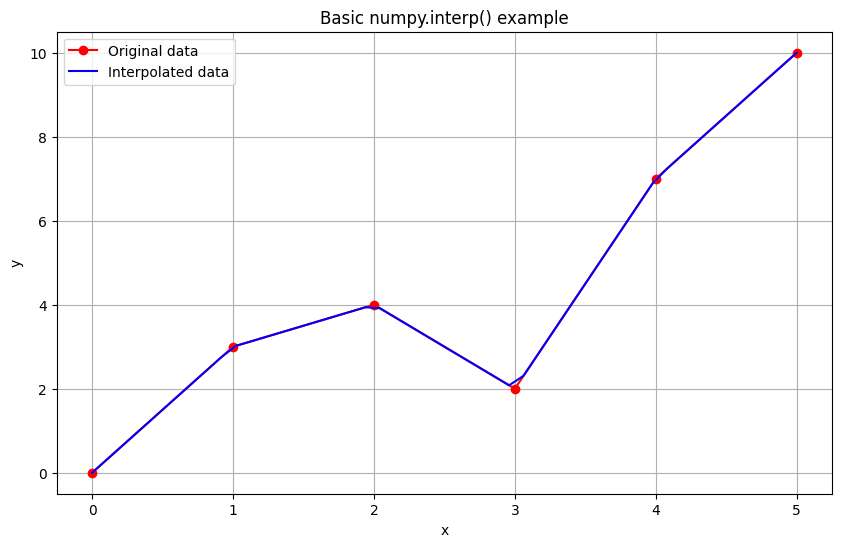

In [42]:
## Demonstrating numpy.interp() function

import numpy
import matplotlib.pyplot as plt
%matplotlib inline

### Basic Usage of numpy.interp()

# Define known x and y values
x = numpy.array([0, 1, 2, 3, 4, 5])
y = numpy.array([0, 3, 4, 2, 7, 10])

# Define x values to interpolate
x_interp = numpy.linspace(0, 5, 50)

# Perform interpolation
y_interp = numpy.interp(x_interp, x, y)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'ro-', label='Original data')
plt.plot(x_interp, y_interp, 'b-', label='Interpolated data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Basic numpy.interp() example')
plt.legend()
plt.grid(True)
plt.show()


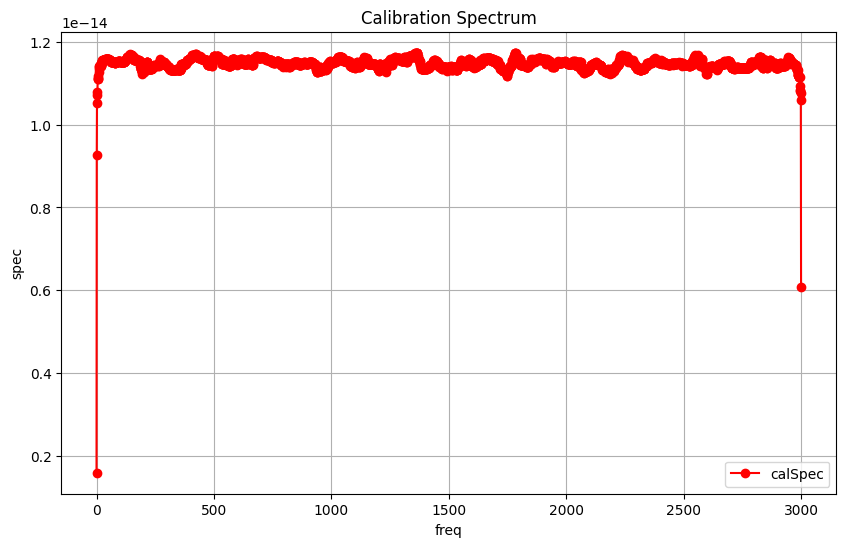

In [43]:
### test calibration spectrum interoplation
import scipy
from IMOSPATools import rawdat
from IMOSPATools import calibration
-90.0
fileName = "../scripts/501E9BF5.DAT"
calSpec, calFreq, fSample = calibration.loadPrepCalibFile(fileName, -90.0, -197.8)

# Plot the calibration spectrum
plt.figure(figsize=(10, 6))
plt.plot(calFreq, calSpec, 'ro-', label='calSpec')
plt.xlabel('freq')
plt.ylabel('spec')
plt.title('Calibration Spectrum')
plt.legend()
plt.grid(True)
plt.show()

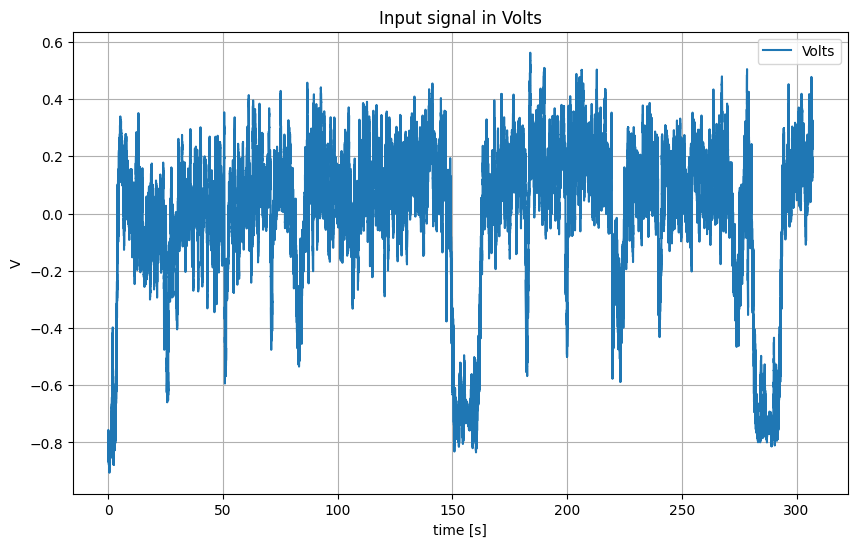

In [44]:
rawFileName = "../scripts/502DB01D.DAT"
binData, numChannels, sampleRate, durationHeader, \
        startTime, endTime = rawdat.readRawFile(rawFileName)
volts = calibration.toVolts(binData)
x = numpy.arange(0, (volts.size)/sampleRate, (1/sampleRate))
from scipy.ndimage import uniform_filter1d
# Calculate moving average - just for plotting
window_size = 2000  # Adjust this value to change the smoothing level
y_avg = uniform_filter1d(volts, size=window_size)
# Plot the Volts
plt.figure(figsize=(10, 6))
plt.plot(x, y_avg, linestyle='-', label='Volts')
plt.xlabel('time [s]')
plt.ylabel('V')
plt.title('Input signal in Volts')
plt.legend()
plt.grid(True)
plt.show()

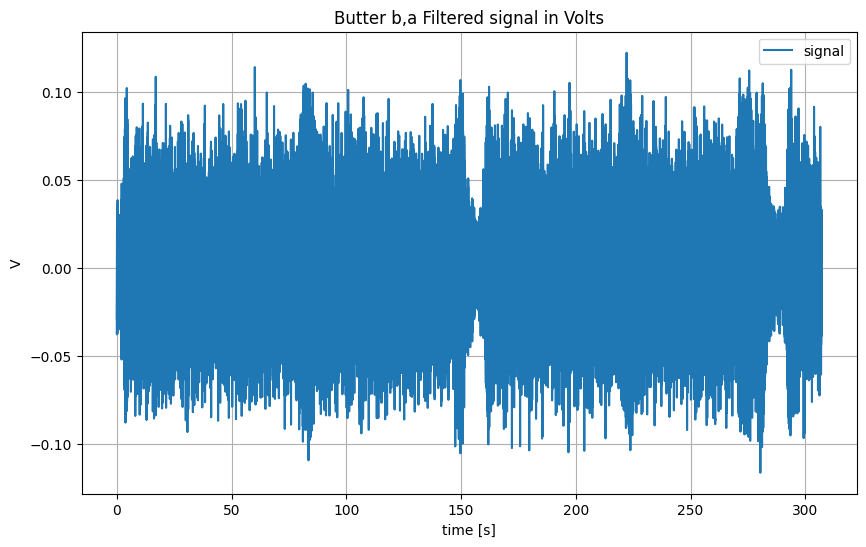

In [45]:
# make high-pass filter to remove slow varying DC offset
b, a = scipy.signal.butter(5, 5/fSample*2, btype='high', output='ba')
# apply the filter on the input signal
signal = scipy.signal.lfilter(b, a, volts)

# Calculate moving average - just for plotting
y_avg = uniform_filter1d(signal, size=window_size)
# Plot the Volts
plt.figure(figsize=(10, 6))
plt.plot(x, y_avg, linestyle='-', label='signal')
plt.xlabel('time [s]')
plt.ylabel('V')
plt.title('Butter b,a Filtered signal in Volts')
plt.legend()
plt.grid(True)
plt.show()

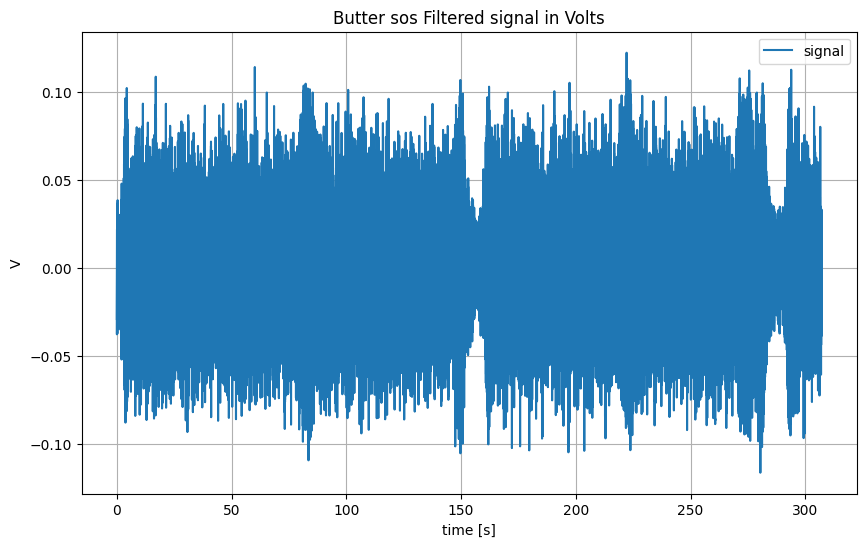

In [46]:
# make high-pass filter to remove slow varying DC offset
sos = scipy.signal.butter(5, 5/fSample*2, btype='high', output='sos')
# apply the filter on the input signal
signal2 = scipy.signal.sosfilt(sos, volts)

# Calculate moving average - just for plotting
y_avg = uniform_filter1d(signal2, size=window_size)
# Plot the Volts
plt.figure(figsize=(10, 6))
plt.plot(x, y_avg, linestyle='-', label='signal')
plt.xlabel('time [s]')
plt.ylabel('V')
plt.title('Butter sos Filtered signal in Volts')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
fmax = calFreq[len(calFreq) - 1]
df = fmax * 2 / len(signal)
# generate a set of frequencies as ndarray
freqFFT = numpy.arange(0, fmax + df, df)

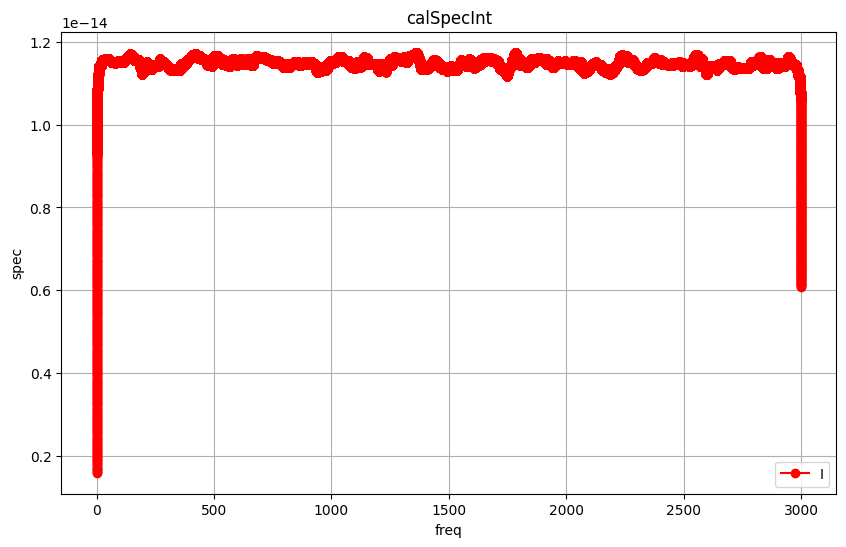

In [48]:
# MC note: the interpolation function numpy.interp() has a different
#          params order compared with matlab function interp1()
calSpecInt = numpy.interp(freqFFT, calFreq, calSpec)

# Plot the interpolated spectrum
plt.figure(figsize=(10, 6))
plt.plot(freqFFT, calSpecInt, 'ro-', label='calSpecInt')
plt.xlabel('freq')
plt.ylabel('spec')
plt.title('calSpecInt')
plt.legend('Interpolated Spectrum')
plt.grid(True)
plt.show()


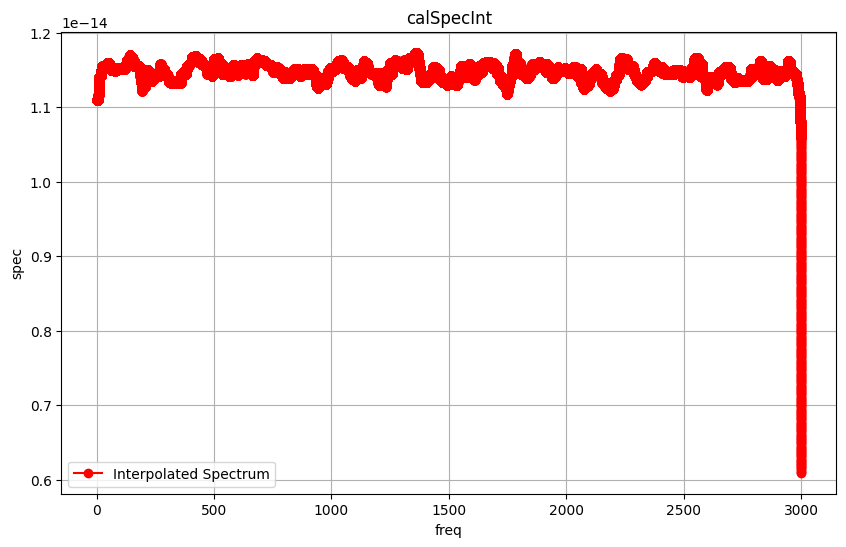

In [49]:
# Ignore calibration values below 5 Hz to avoid inadequate correction
N5Hz = numpy.where(freqFFT <= 5)[0]
calSpecInt[N5Hz] = calSpecInt[N5Hz[-1]]

# Plot the interpolated spectrum
plt.figure(figsize=(10, 6))
plt.plot(freqFFT, calSpecInt, 'ro-', label='Interpolated Spectrum')
plt.xlabel('freq')
plt.ylabel('spec')
plt.title('calSpecInt')
plt.legend()
plt.grid(True)
plt.show()

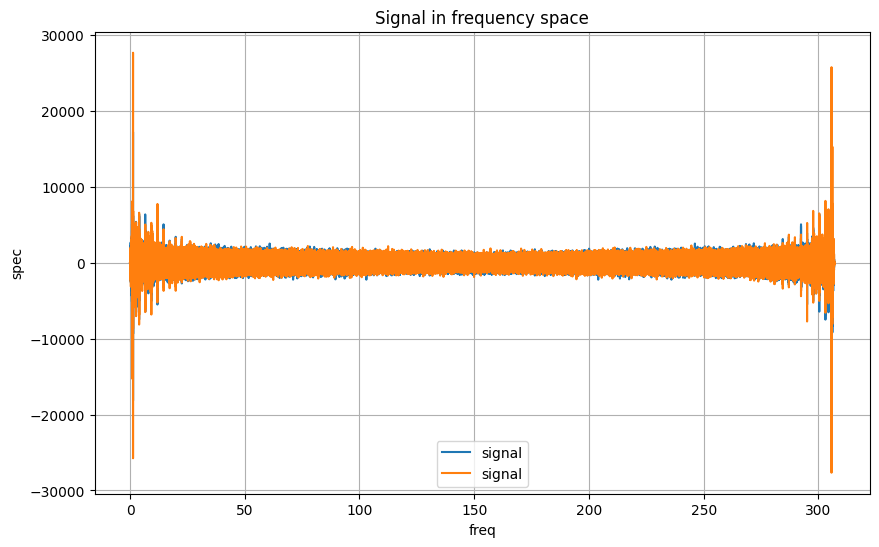

In [52]:
spec = numpy.fft.fft(signal)

# Calculate moving average - just for plotting
y_r = uniform_filter1d(spec.real, size=100)
y_i = uniform_filter1d(spec.imag, size=100)
# Plot the Volts
plt.figure(figsize=(10, 6))
plt.plot(x, y_r, linestyle='-', label='real')
plt.plot(x, y_i, linestyle='-', label='imag')
plt.xlabel('freq')
plt.ylabel('spec')
plt.title('Signal in frequency space')
plt.legend()
plt.grid(True)
plt.show()

Calibrated signal after IFFT contains non-zero imaginary component(s)


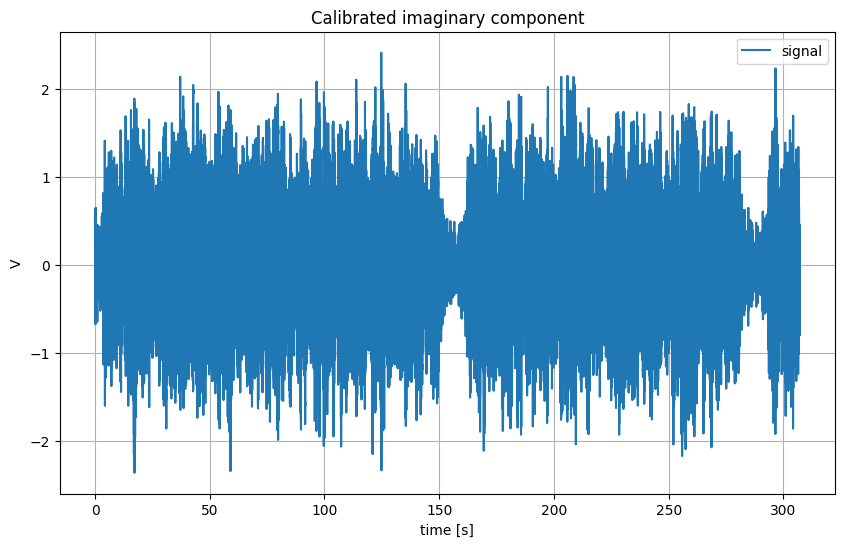

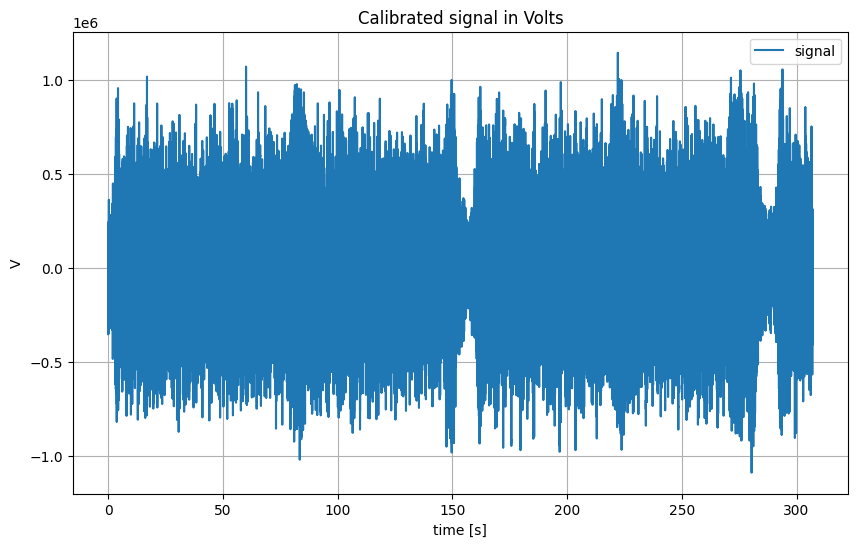

In [50]:
spec = numpy.fft.fft(signal)


# Calculate moving average - just for plotting
y_avg = uniform_filter1d(calibratedSignal, size=window_size)
# Plot the Volts
plt.figure(figsize=(10, 6))
plt.plot(x, y_avg, linestyle='-', label='signal')
plt.xlabel('time [s]')
plt.ylabel('V')
plt.title('Calibrated signal in Volts')
plt.legend()
plt.grid(True)
plt.show()

Calibrated signal after IFFT contains non-zero imaginary component(s)


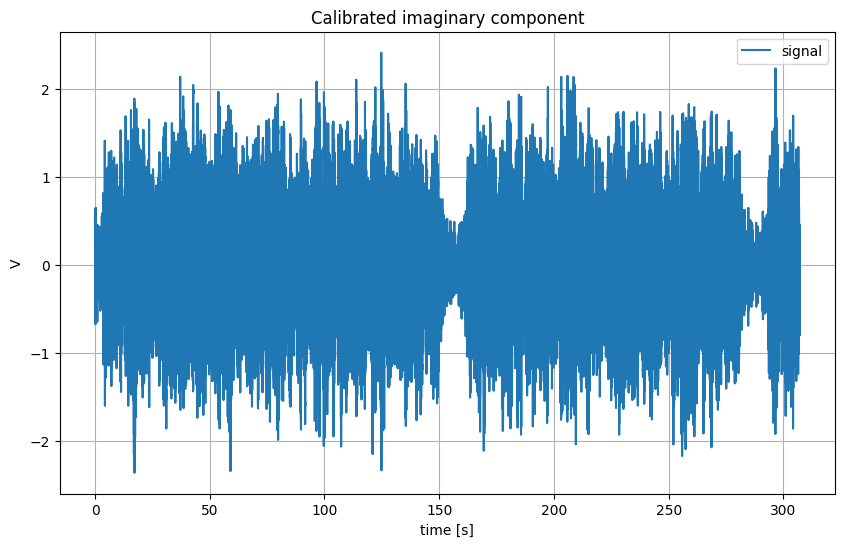

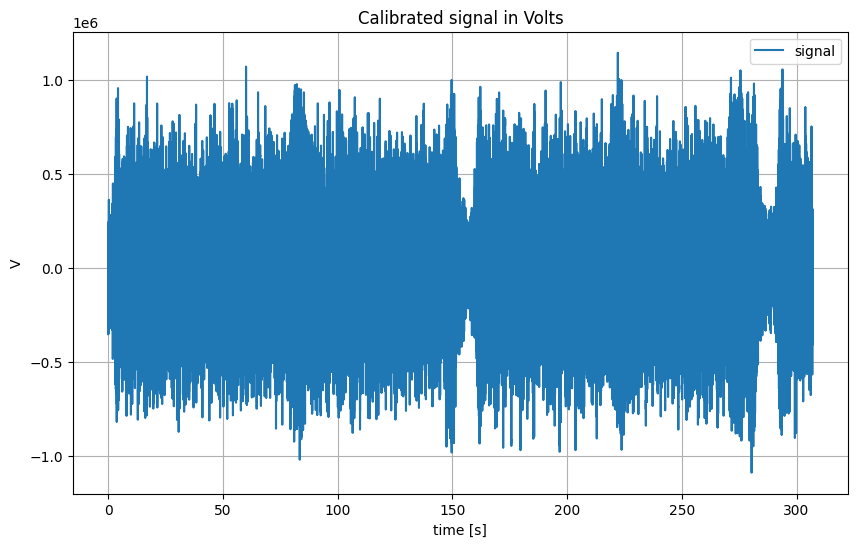

In [50]:
if numpy.floor(len(signal) / 2) == len(signal) / 2:
    calibratedSignal = numpy.fft.ifft(spec / numpy.sqrt(numpy.concatenate((calSpecInt[1:], calSpecInt[::-1][:-1]))))
else:
    calibratedSignal = numpy.fft.ifft(spec / numpy.sqrt(numpy.concatenate((calSpecInt, calSpecInt[::-1][:-1]))))
if not numpy.allclose(calibratedSignal.imag, 0.0):
    logMsg = "Calibrated signal after IFFT contains non-zero imaginary component(s)"
    print(logMsg)
    # Calculate moving average - just for plotting
    y_avg = uniform_filter1d(calibratedSignal.imag, size=window_size)
    # Plot the Volts
    plt.figure(figsize=(10, 6))
    plt.plot(x, y_avg, linestyle='-', label='signal')
    plt.xlabel('time [s]')
    plt.ylabel('V')
    plt.title('Calibrated imaginary component')
    plt.legend()
    plt.grid(True)
    plt.show()

calibratedSignal = calibratedSignal.real

# Calculate moving average - just for plotting
y_avg = uniform_filter1d(calibratedSignal, size=window_size)
# Plot the Volts
plt.figure(figsize=(10, 6))
plt.plot(x, y_avg, linestyle='-', label='signal')
plt.xlabel('time [s]')
plt.ylabel('V')
plt.title('Calibrated signal in Volts')
plt.legend()
plt.grid(True)
plt.show()